In [17]:
#import the libraries
import torch,pdb
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt





In [26]:
#visualization function
def show(tensor,ch=1,size=(28,28),num=16):
  #tensor:128 X
  data=tensor.detach().cpu().view(-1,ch,*size) # 128 x 1 x 28 x 28
  grid= make_grid(data[:num],nrow=4).permute(1,2,0) #1 x 28 x 28 = 28 x 28 x 1
  plt.imshow(grid)
  plt.show()

In [19]:
# setup of the main parameters and hyperparameters
epochs=500
cur_step=0
info_step=300
mean_gen_loss=0
mean_disc_loss=0

z_dim=64
lr = 0.00001 #learning rate
loss_func=nn.BCEWithLogitsLoss()

bs=128   #batch size
device='cuda'

dataloader =DataLoader(MNIST('.',download=True,transform=transforms.ToTensor()),shuffle=True,batch_size=bs)






In [20]:
# declare our models

# generator of each block
def genBlock(inp,out): # input and output size
  return nn.Sequential(
    nn.Linear(inp,out),
    nn.BatchNorm1d(out),
    nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self,z_dim,i_dim=784,h_dim=128):
    super().__init__()
    self.gen=nn.Sequential(
        genBlock(z_dim,h_dim), #64, 128
        genBlock(h_dim,h_dim*2), #128 ,256
        genBlock(h_dim*2,h_dim*4), #256 ,512
        genBlock(h_dim*4,h_dim*8), #512,1024
        nn.Linear(h_dim*8,i_dim),#1024,784
        nn.Sigmoid()
    )

  def forward(self,noise):
      return self.gen(noise)

def gen_noise(number,z_dim):
  return torch.randn(number,z_dim).to(device)



# Discriminator

def discBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.LeakyReLU(0,2)
  )

class Discrimainator(nn.Module):
  def __init__(self,i_dim=784,h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim,h_dim*4), #784,1024
        discBlock(h_dim*4,h_dim*2), #1024,512
        discBlock(h_dim*2,h_dim),  #512,256
        nn.Linear(h_dim,1) #256,1
    )

  def forward(self,image):
      return self.disc(image)




In [21]:
gen=Generator(z_dim).to(device)
gen_opt=torch.optim.Adam(gen.parameters(),lr=lr)
disc=Discrimainator().to(device)
disc_opt=torch.optim.Adam(disc.parameters(),lr=lr)


In [22]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [23]:
disc


Discrimainator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0, inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0, inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0, inplace=True)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([5, 4, 3, 6, 4, 6, 4, 8, 1, 0])


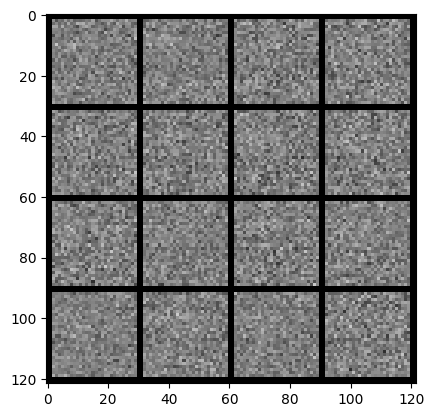

In [39]:
x,y=next(iter(dataloader))
print(x.shape,y.shape)
print(y[:10])

noise=gen_noise(bs,z_dim)
fake=gen(noise)
show(fake)

In [40]:
# here what you are seeing here is the initial output of passing the noise through the generator.
#because the generator did not begin to learn,it produce a very noise output
#now we go to try to tain the network to produce the images of the numbers

In [43]:
# calculating the loss

# generator loss

def calc_gen_loss(loss_func,gen,disc,number,z_dim):
  noise=gen_noise(number,z_dim)
  fake=gen(noise)
  pred=disc(fake)
  targets=torch.ones_like(pred)
  gen_loss=loss_func(pred,targets)
  return gen_loss

def calc_disc_loss(loss_func,gen,disc,number,real,z_dim):
  noise=gen_noise(number,z_dim)
  fake=gen(noise)
  disc_fake=disc(fake.detach())
  disc_fake_target=torch.zeros_like(disc_fake)
  disc_fake_loss=loss_func(disc_fake,disc_fake_target)

  disc_real=disc(real)
  disc_real_target=torch.ones_like(disc_real)
  disc_real_loss=loss_func(disc_real,disc_real_target)

  disc_loss=(disc_fake_loss+disc_real_loss)/2

  return disc_loss

  0%|          | 0/469 [00:00<?, ?it/s]

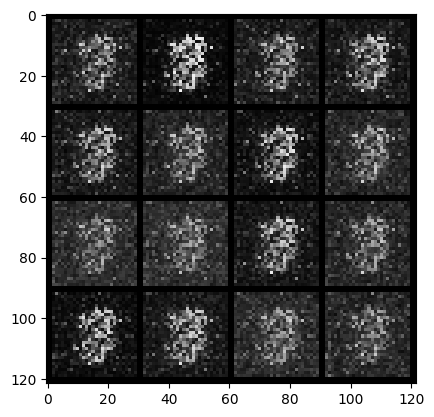

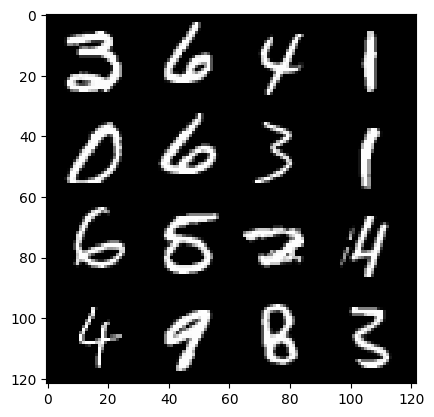

0: step 300 / Gen loss : 1.5300108754634854 /disc_loss: 0.3463899955898522 


  0%|          | 0/469 [00:00<?, ?it/s]

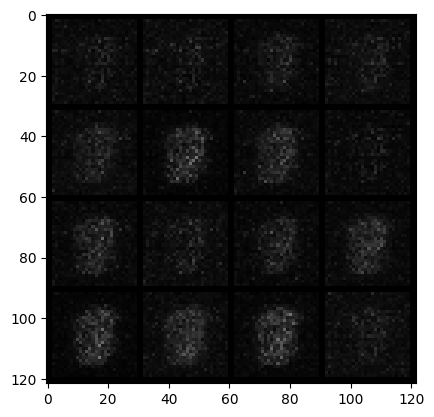

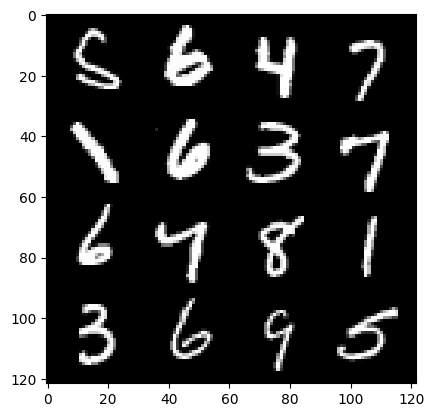

1: step 600 / Gen loss : 2.486466663678488 /disc_loss: 0.07888412321607273 


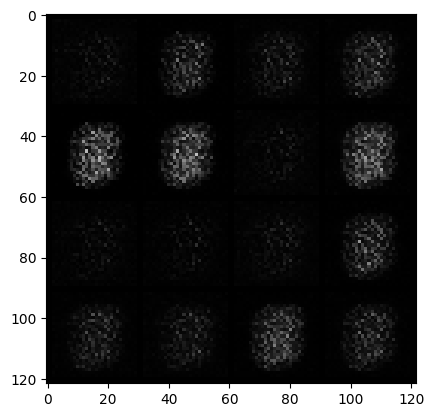

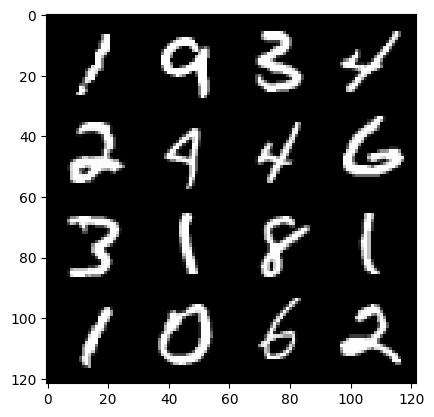

1: step 900 / Gen loss : 2.190705743630728 /disc_loss: 0.10741061401863886 


  0%|          | 0/469 [00:00<?, ?it/s]

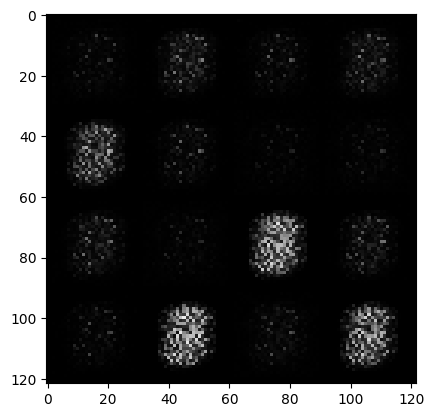

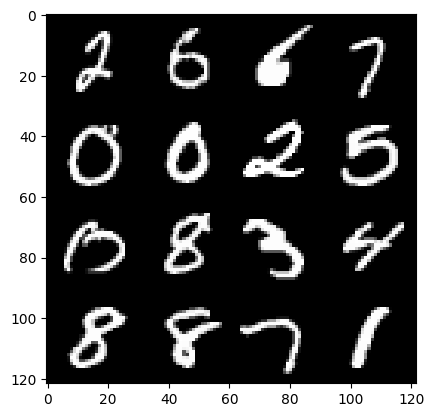

2: step 1200 / Gen loss : 2.2710626721382146 /disc_loss: 0.08919421336303156 


  0%|          | 0/469 [00:00<?, ?it/s]

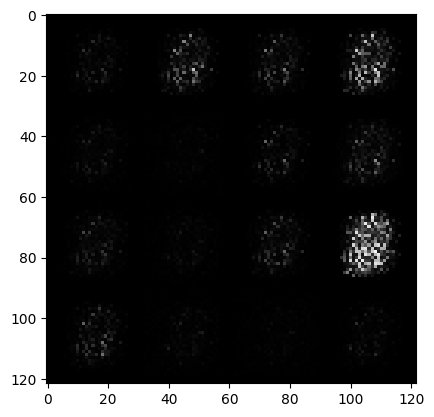

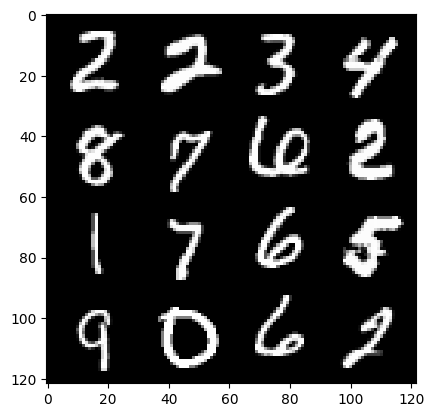

3: step 1500 / Gen loss : 2.747383564313254 /disc_loss: 0.05072023383031289 


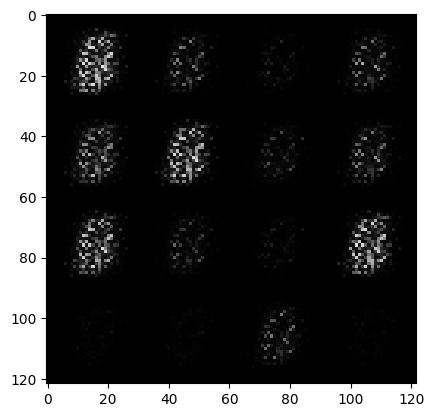

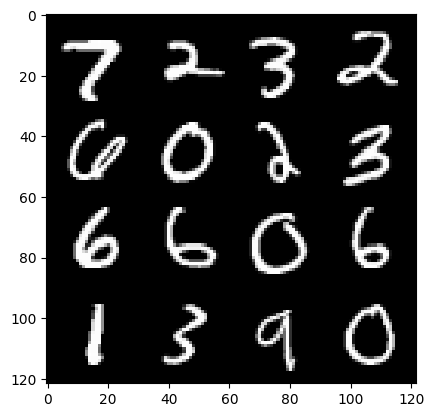

3: step 1800 / Gen loss : 3.1180305552482603 /disc_loss: 0.03533371952672797 


  0%|          | 0/469 [00:00<?, ?it/s]

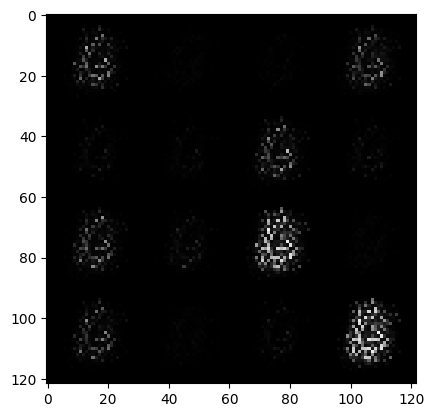

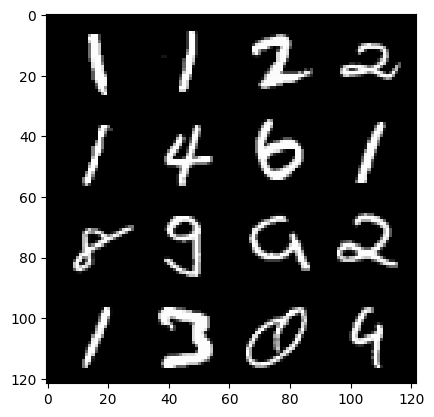

4: step 2100 / Gen loss : 3.5215888587633777 /disc_loss: 0.024540737501035127 


  0%|          | 0/469 [00:00<?, ?it/s]

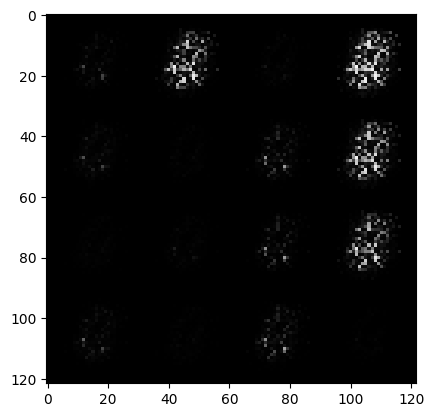

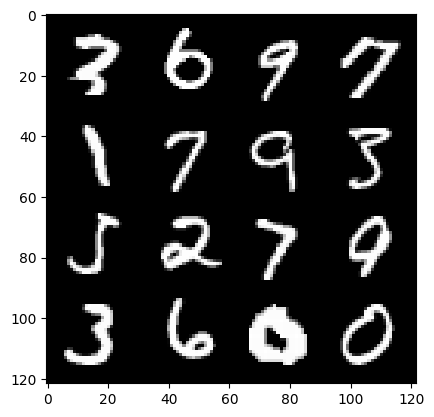

5: step 2400 / Gen loss : 3.8416826852162673 /disc_loss: 0.018271025388191142 


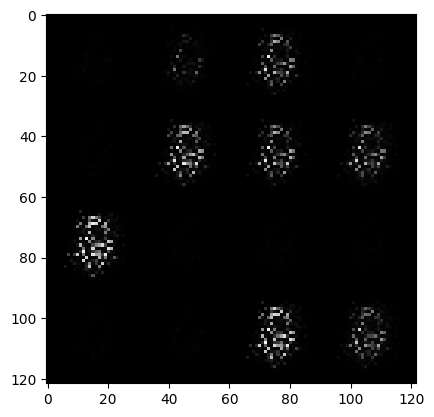

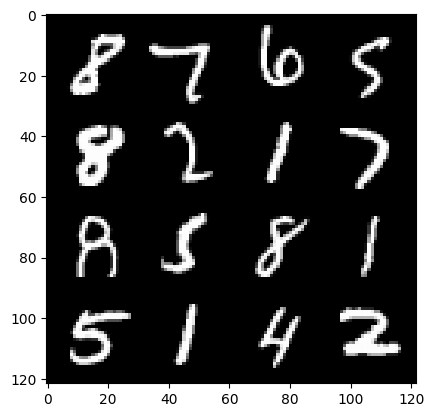

5: step 2700 / Gen loss : 4.144350966612498 /disc_loss: 0.012675964611892895 


  0%|          | 0/469 [00:00<?, ?it/s]

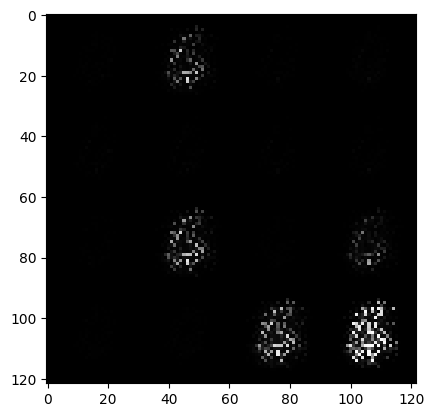

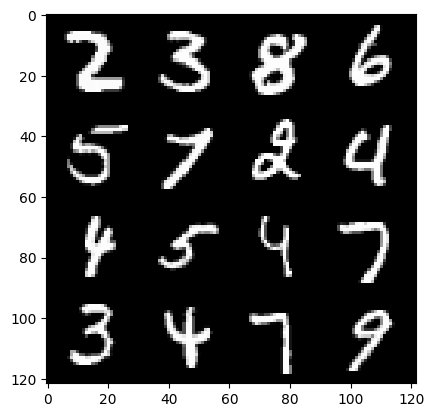

6: step 3000 / Gen loss : 4.521622749964396 /disc_loss: 0.008823187601131698 


  0%|          | 0/469 [00:00<?, ?it/s]

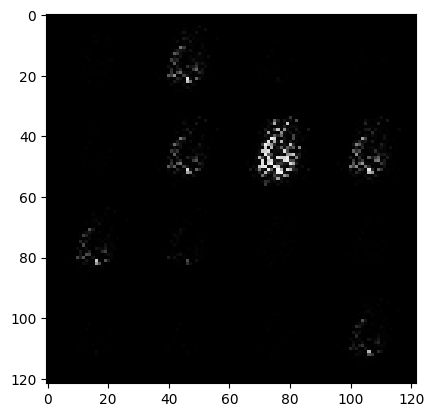

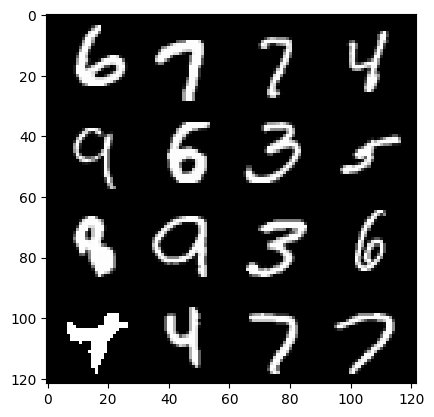

7: step 3300 / Gen loss : 4.8147185103098575 /disc_loss: 0.008081641374155879 


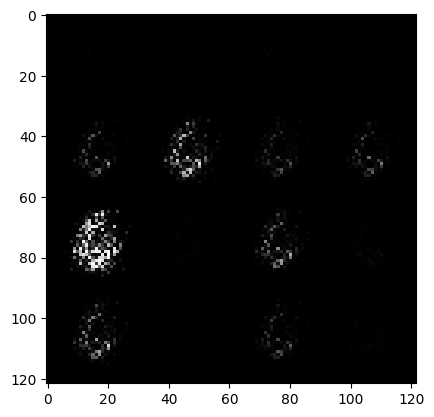

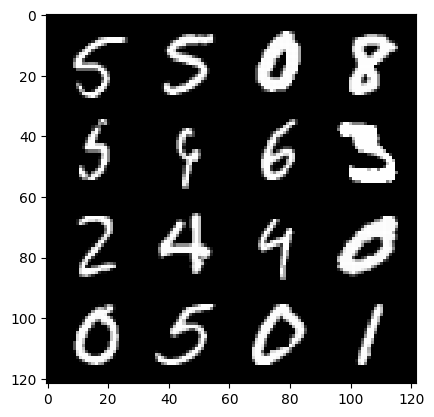

7: step 3600 / Gen loss : 5.242532130877177 /disc_loss: 0.006163714227732271 


  0%|          | 0/469 [00:00<?, ?it/s]

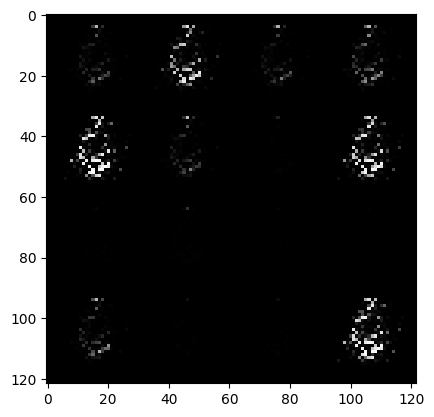

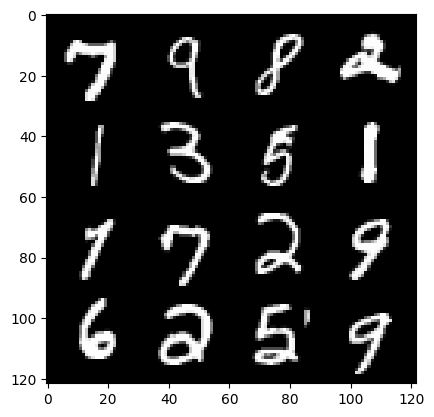

8: step 3900 / Gen loss : 5.4101757621765145 /disc_loss: 0.004063891173961261 


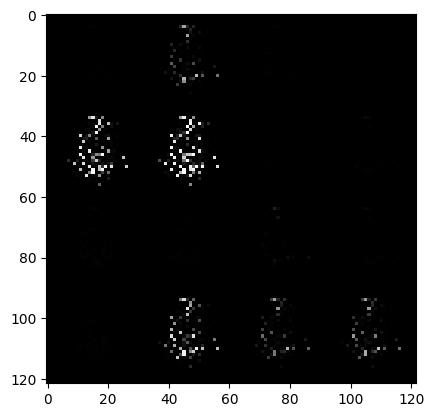

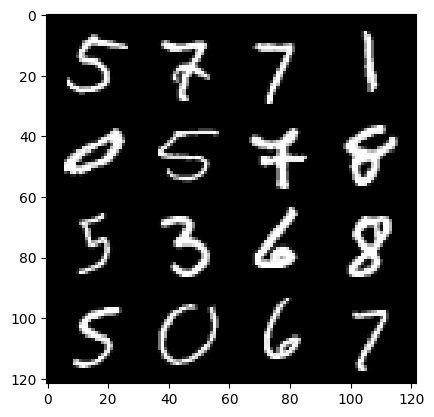

8: step 4200 / Gen loss : 5.711405374209086 /disc_loss: 0.0024590620177332304 


  0%|          | 0/469 [00:00<?, ?it/s]

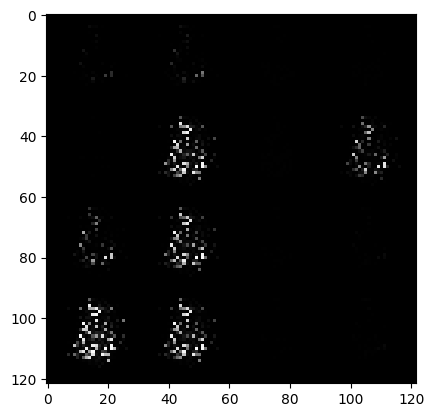

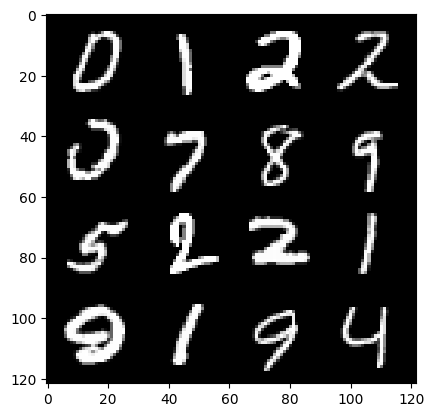

9: step 4500 / Gen loss : 5.961715949376425 /disc_loss: 0.002238103550237914 


  0%|          | 0/469 [00:00<?, ?it/s]

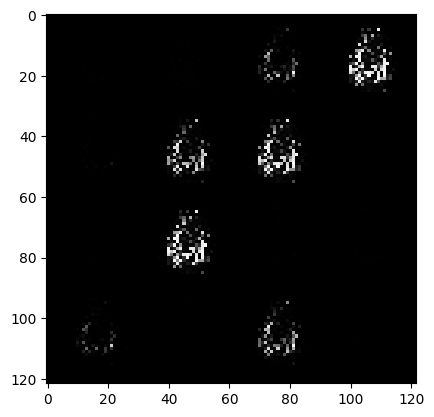

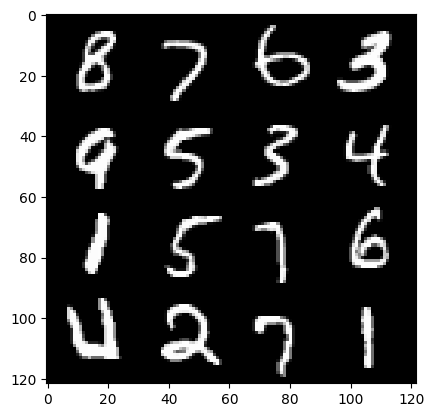

10: step 4800 / Gen loss : 6.151537087758378 /disc_loss: 0.0024196862685494126 


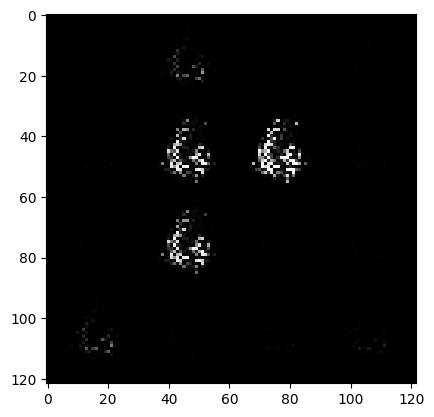

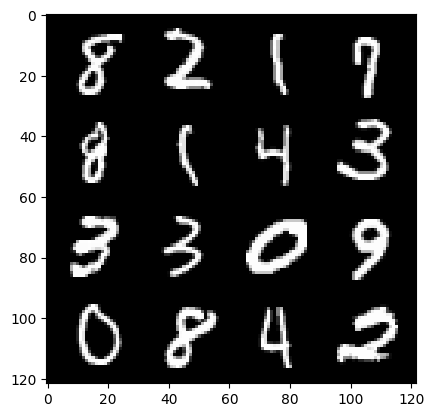

10: step 5100 / Gen loss : 6.482393639882408 /disc_loss: 0.0021618415547224384 


  0%|          | 0/469 [00:00<?, ?it/s]

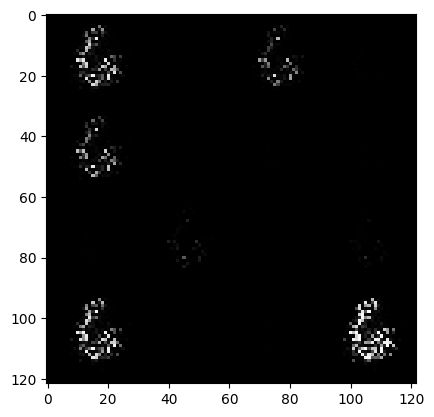

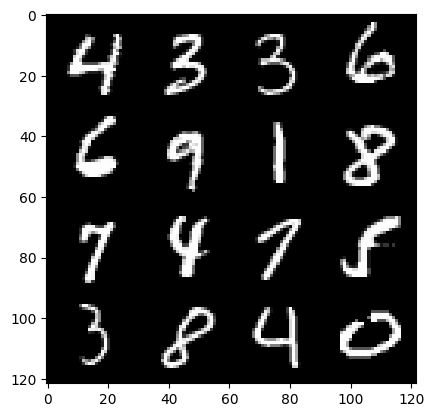

11: step 5400 / Gen loss : 6.564030318260195 /disc_loss: 0.002044476103231621 


  0%|          | 0/469 [00:00<?, ?it/s]

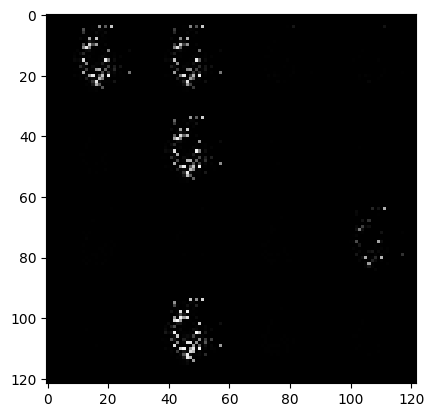

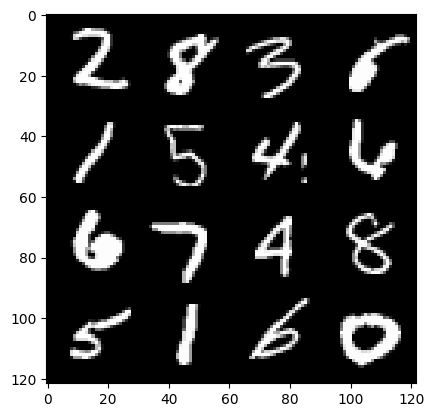

12: step 5700 / Gen loss : 6.650287454922992 /disc_loss: 0.0015504776930902145 


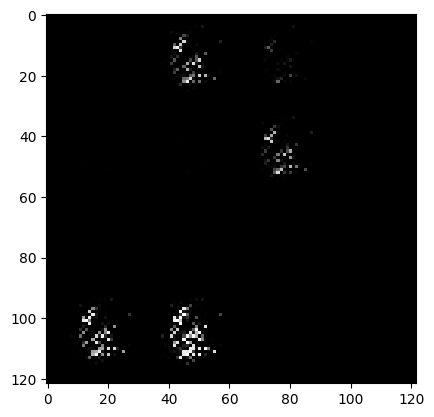

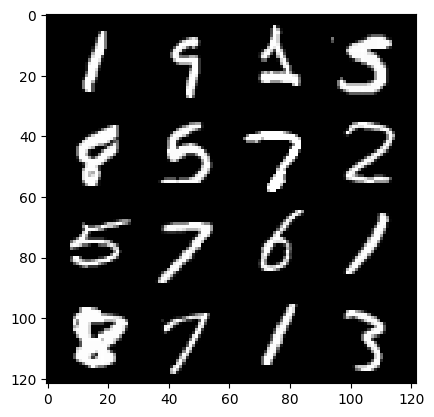

12: step 6000 / Gen loss : 7.032045386632283 /disc_loss: 0.001138191939874863 


  0%|          | 0/469 [00:00<?, ?it/s]

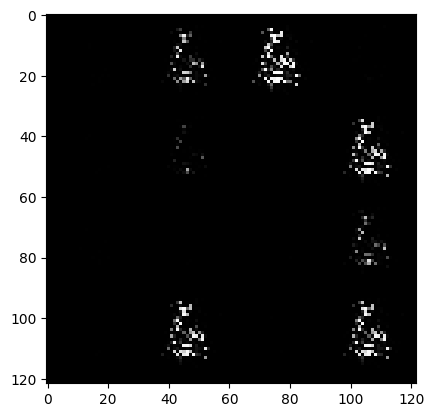

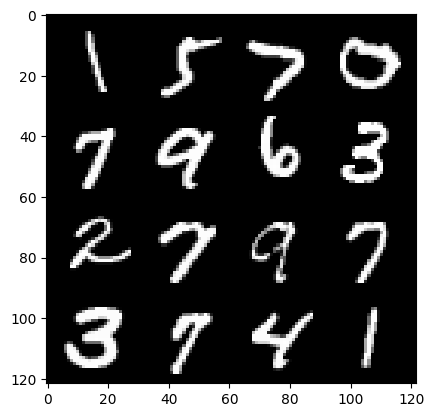

13: step 6300 / Gen loss : 7.073361048698427 /disc_loss: 0.001047204531011327 


  0%|          | 0/469 [00:00<?, ?it/s]

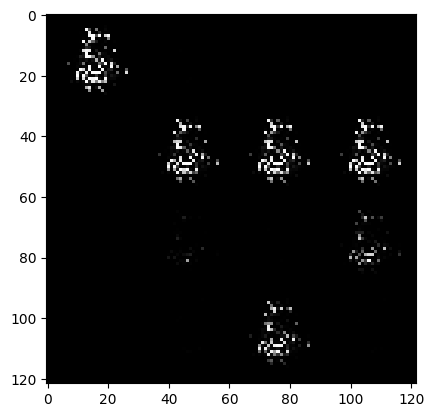

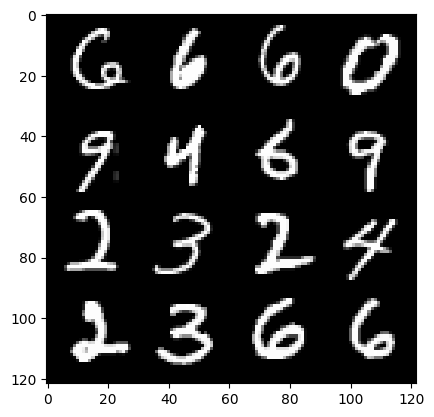

14: step 6600 / Gen loss : 7.199957083066302 /disc_loss: 0.0009187048880266959 


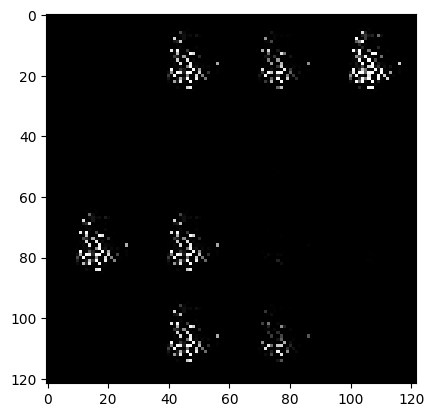

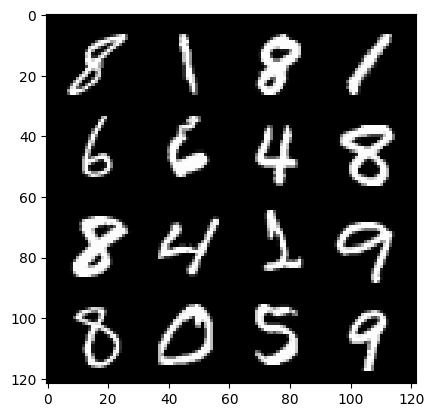

14: step 6900 / Gen loss : 7.314063436190286 /disc_loss: 0.0008800720370102987 


  0%|          | 0/469 [00:00<?, ?it/s]

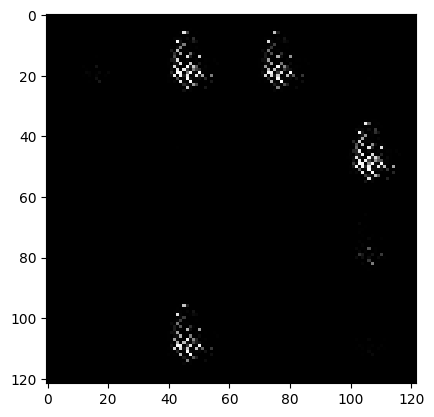

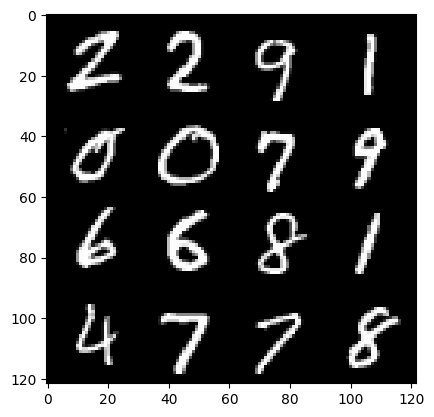

15: step 7200 / Gen loss : 7.626555091540018 /disc_loss: 0.0008095935138408093 


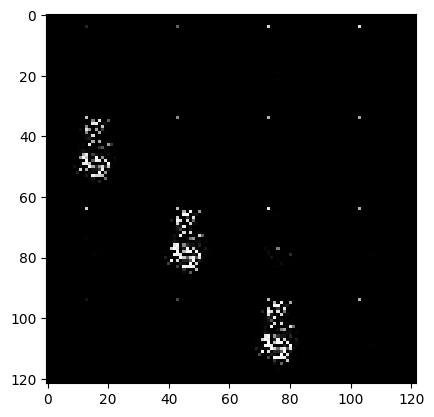

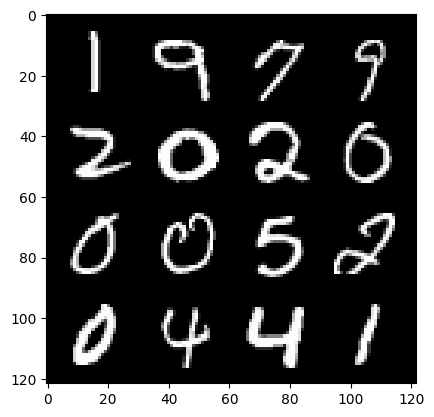

15: step 7500 / Gen loss : 7.675416847864785 /disc_loss: 0.0011310455544056208 


  0%|          | 0/469 [00:00<?, ?it/s]

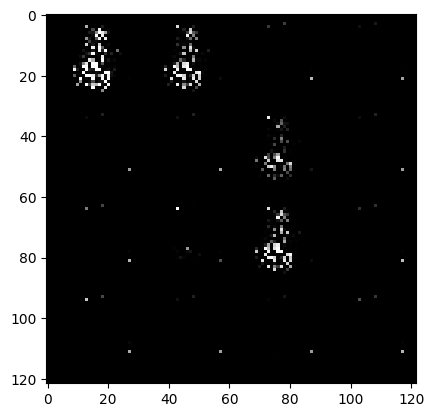

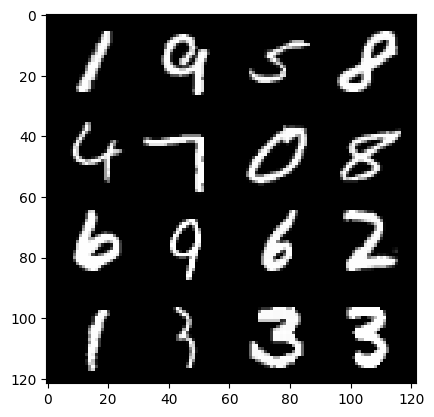

16: step 7800 / Gen loss : 7.950554520289108 /disc_loss: 0.0007927355712551313 


  0%|          | 0/469 [00:00<?, ?it/s]

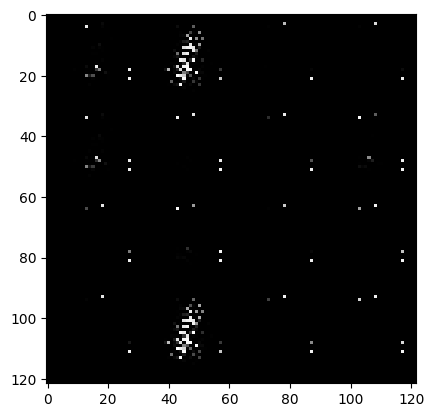

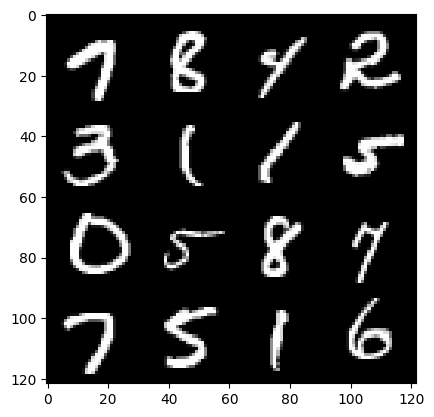

17: step 8100 / Gen loss : 8.029908126195268 /disc_loss: 0.0006540588054243314 


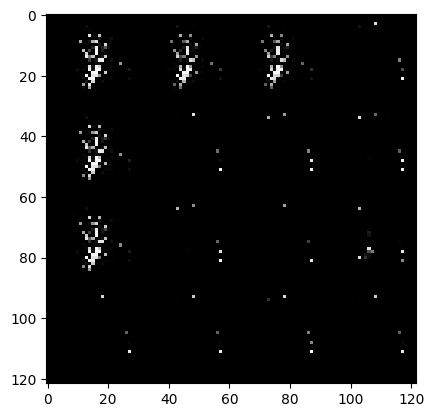

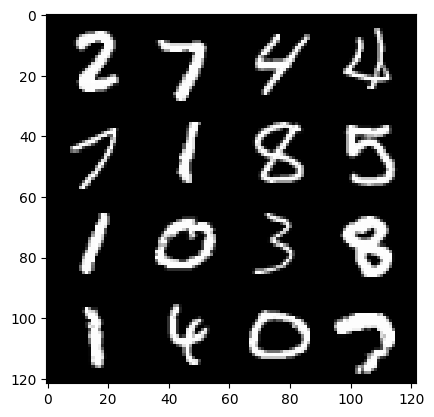

17: step 8400 / Gen loss : 9.022914867401127 /disc_loss: 0.0005934169469401231 


  0%|          | 0/469 [00:00<?, ?it/s]

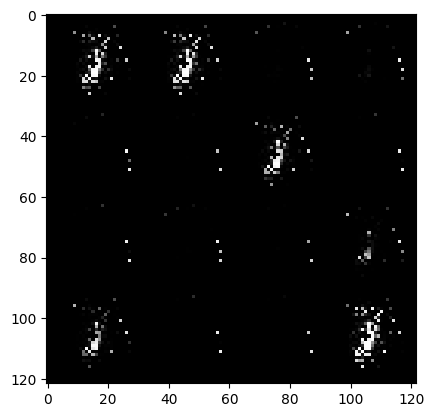

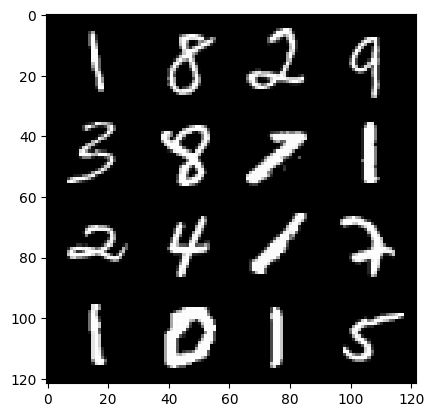

18: step 8700 / Gen loss : 8.819924914042149 /disc_loss: 0.0006278422583515441 


  0%|          | 0/469 [00:00<?, ?it/s]

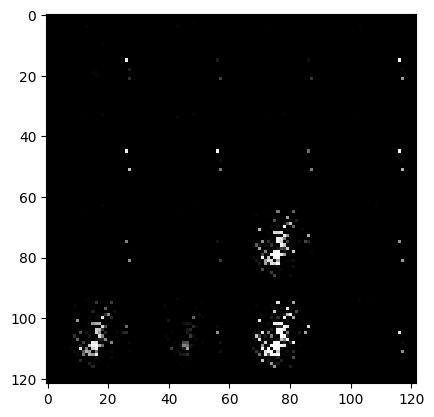

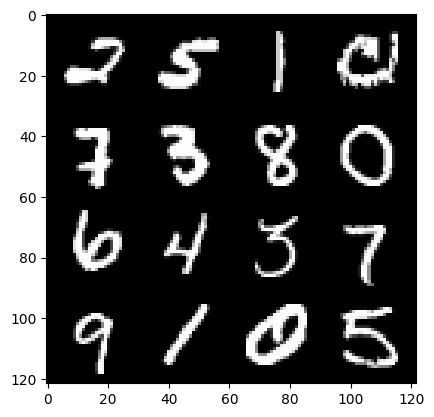

19: step 9000 / Gen loss : 9.190880476633705 /disc_loss: 0.0006387779729993785 


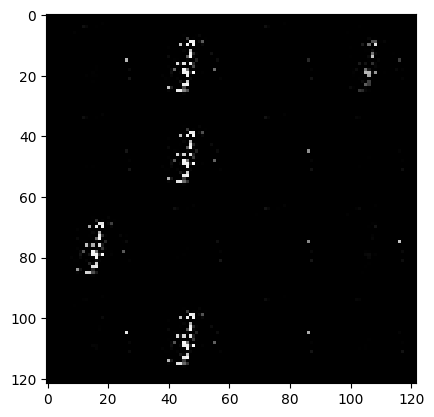

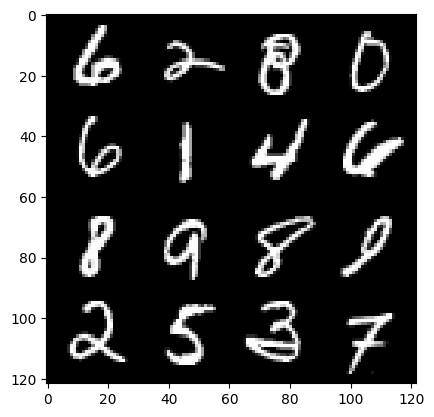

19: step 9300 / Gen loss : 8.660122197469075 /disc_loss: 0.0009945842504869992 


  0%|          | 0/469 [00:00<?, ?it/s]

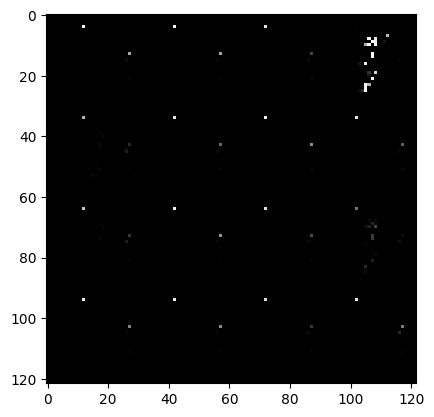

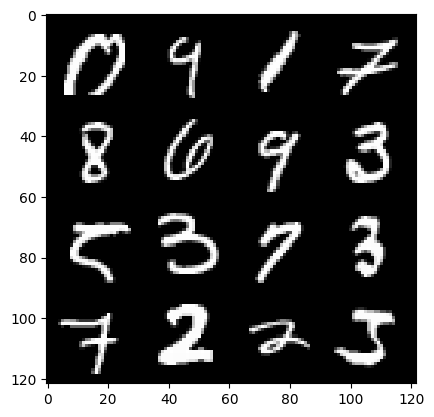

20: step 9600 / Gen loss : 8.362129549980166 /disc_loss: 0.0005800262760021722 


  0%|          | 0/469 [00:00<?, ?it/s]

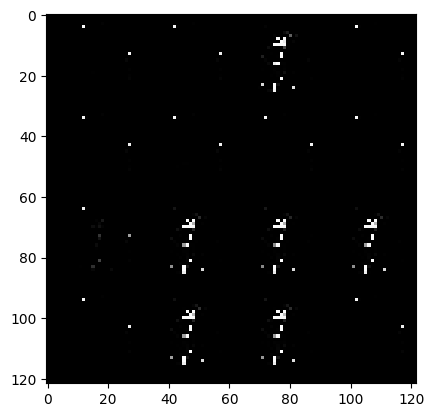

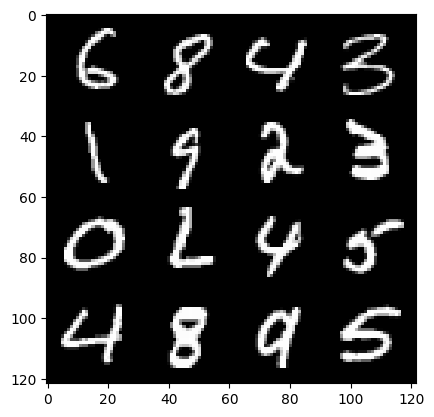

21: step 9900 / Gen loss : 8.243822053273515 /disc_loss: 0.0002908706327434631 


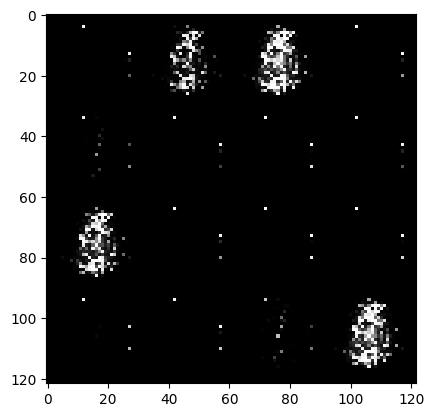

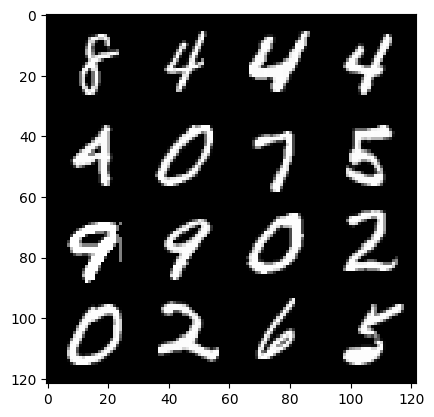

21: step 10200 / Gen loss : 9.178758557637535 /disc_loss: 0.0010889664654193131 


  0%|          | 0/469 [00:00<?, ?it/s]

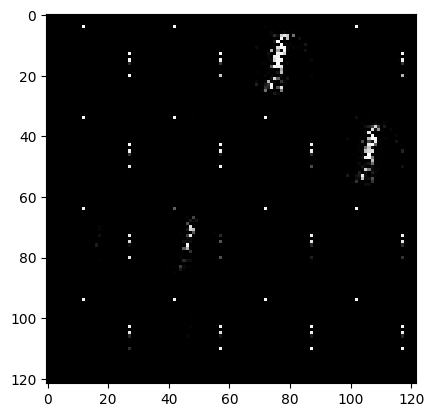

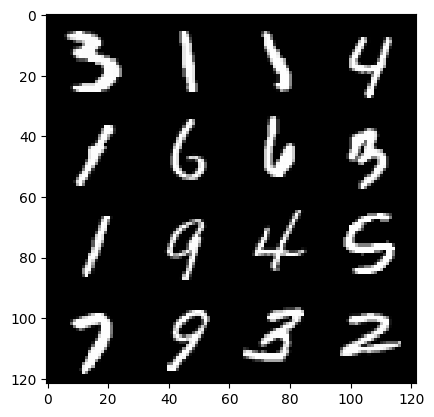

22: step 10500 / Gen loss : 9.151916357676182 /disc_loss: 0.0020422856241809006 


  0%|          | 0/469 [00:00<?, ?it/s]

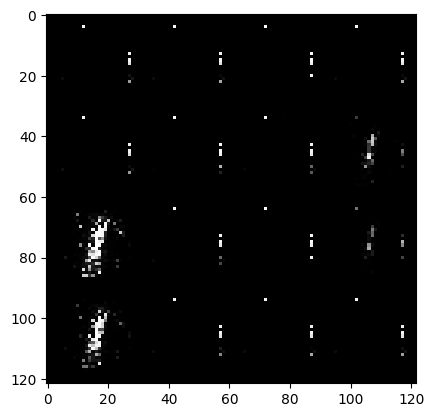

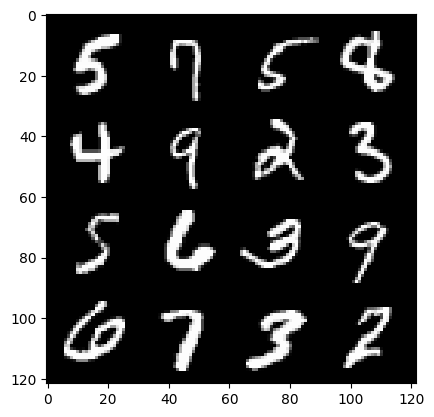

23: step 10800 / Gen loss : 9.220872659683227 /disc_loss: 0.0015466933991410776 


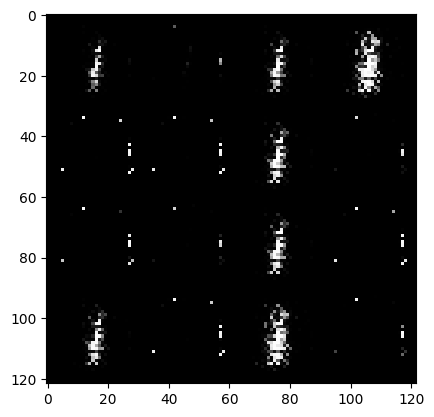

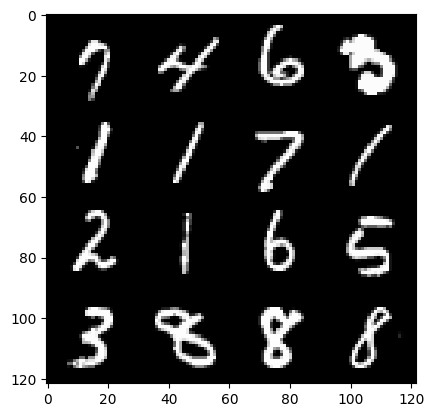

23: step 11100 / Gen loss : 9.221487086613969 /disc_loss: 0.0028733361852937367 


  0%|          | 0/469 [00:00<?, ?it/s]

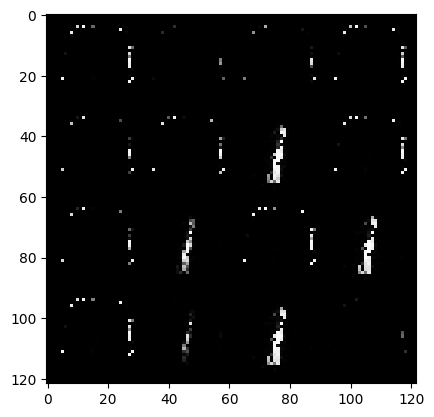

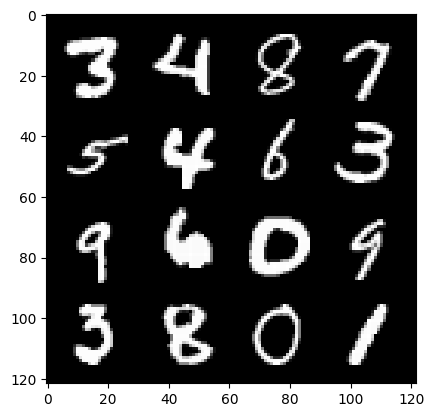

24: step 11400 / Gen loss : 9.094715588887528 /disc_loss: 0.002256451597980534 


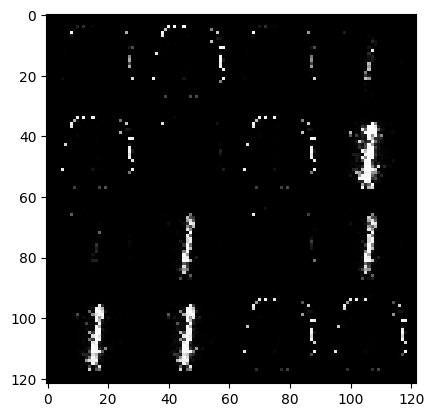

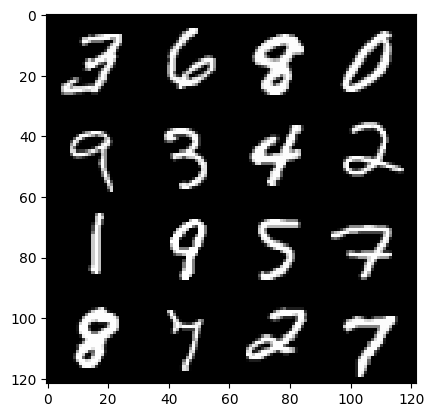

24: step 11700 / Gen loss : 8.955398753484094 /disc_loss: 0.001970989362162072 


  0%|          | 0/469 [00:00<?, ?it/s]

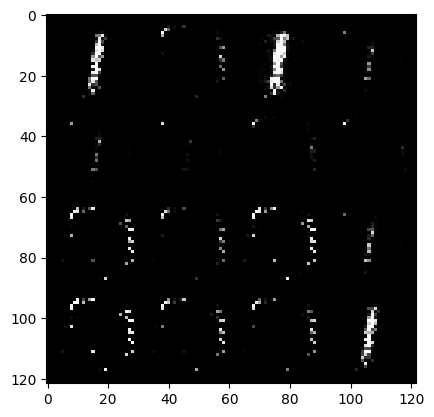

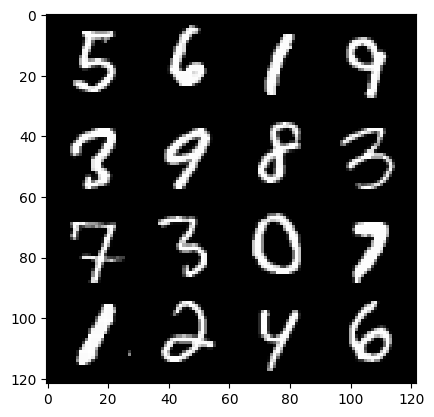

25: step 12000 / Gen loss : 8.487405656178792 /disc_loss: 0.006309622238040904 


  0%|          | 0/469 [00:00<?, ?it/s]

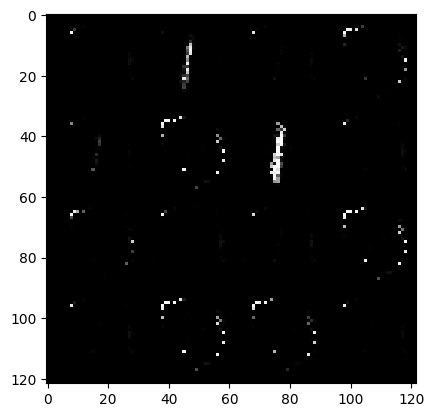

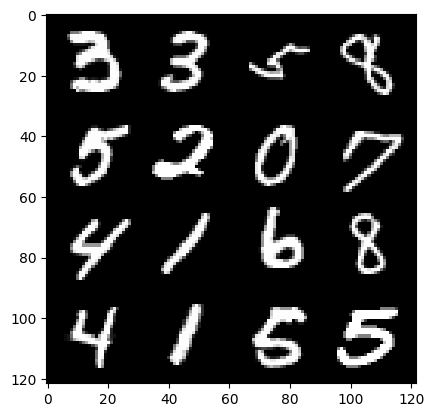

26: step 12300 / Gen loss : 8.342736253738398 /disc_loss: 0.005531774125799226 


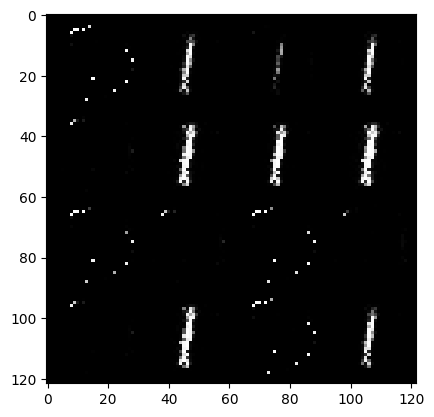

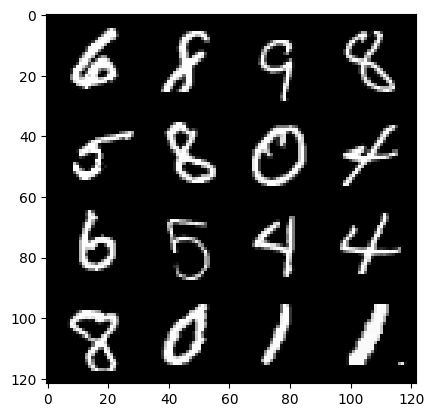

26: step 12600 / Gen loss : 8.619958651860564 /disc_loss: 0.0067041451922462605 


  0%|          | 0/469 [00:00<?, ?it/s]

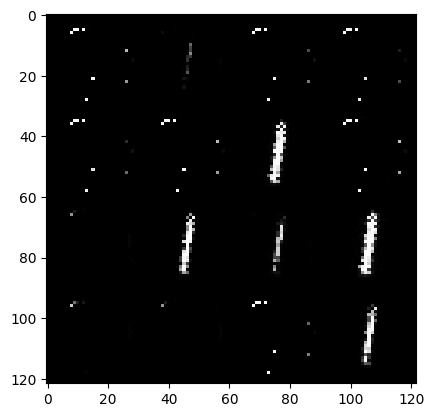

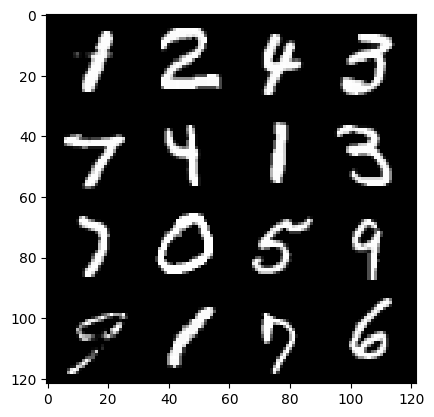

27: step 12900 / Gen loss : 8.470461290677394 /disc_loss: 0.006958522119675764 


  0%|          | 0/469 [00:00<?, ?it/s]

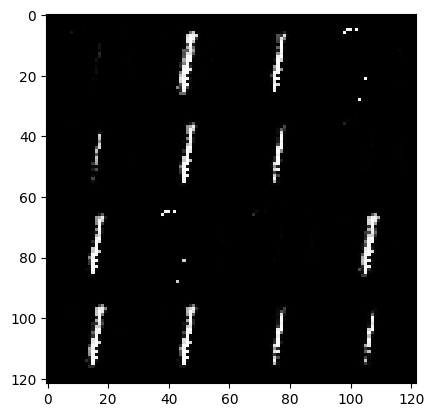

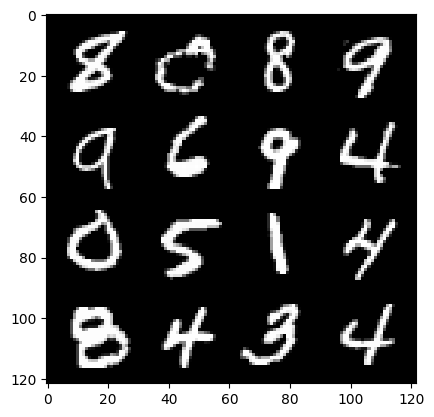

28: step 13200 / Gen loss : 8.357196022669472 /disc_loss: 0.006367351627171346 


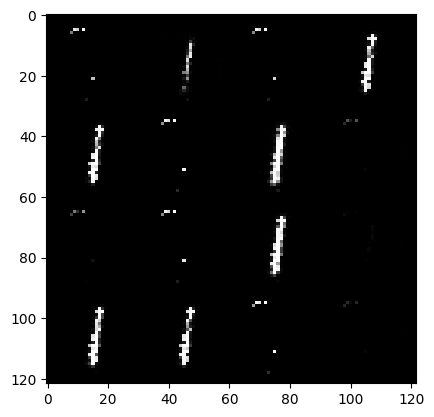

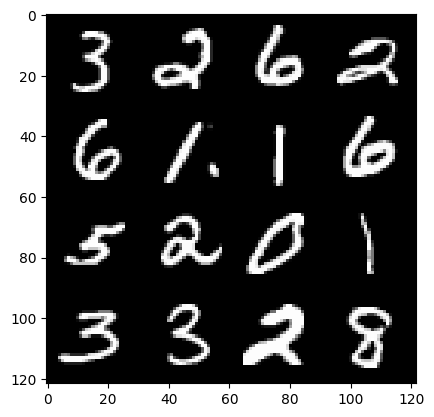

28: step 13500 / Gen loss : 8.548547840118411 /disc_loss: 0.005039187474564342 


  0%|          | 0/469 [00:00<?, ?it/s]

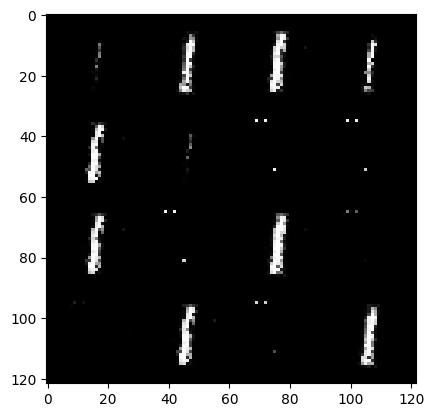

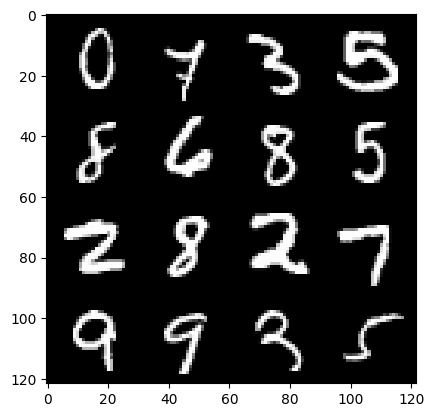

29: step 13800 / Gen loss : 7.990806598663331 /disc_loss: 0.009570688727544623 


  0%|          | 0/469 [00:00<?, ?it/s]

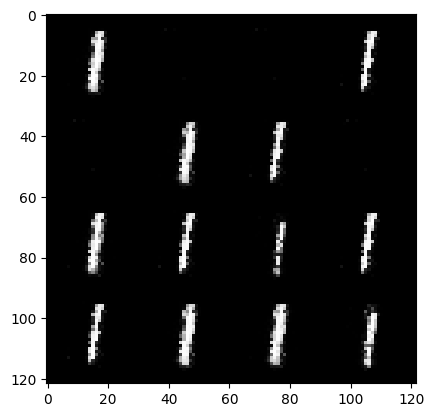

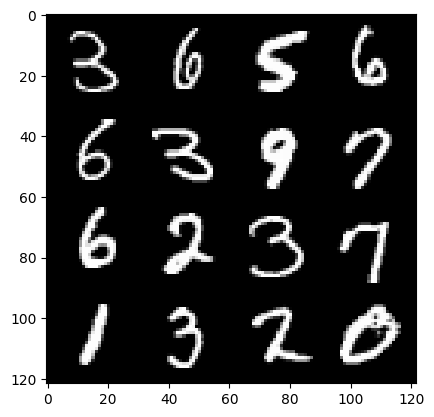

30: step 14100 / Gen loss : 7.331452093124386 /disc_loss: 0.012523032867272082 


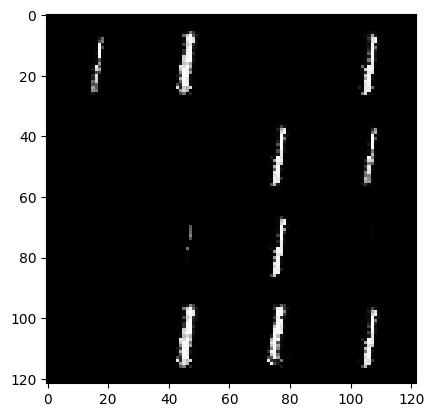

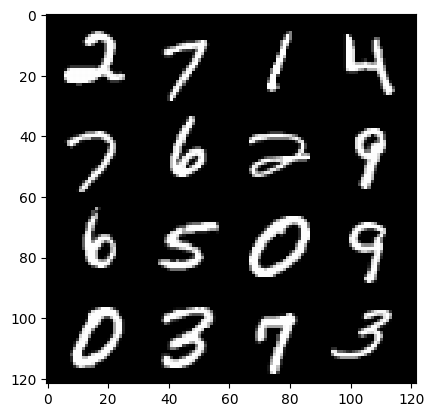

30: step 14400 / Gen loss : 6.894527872403459 /disc_loss: 0.013332001262654875 


  0%|          | 0/469 [00:00<?, ?it/s]

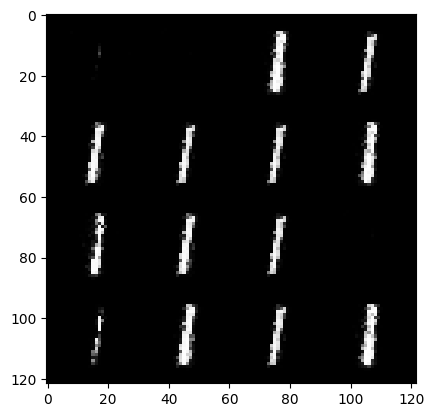

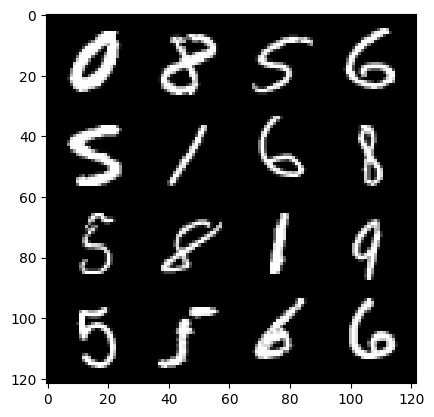

31: step 14700 / Gen loss : 7.199165811538697 /disc_loss: 0.016528361287976925 


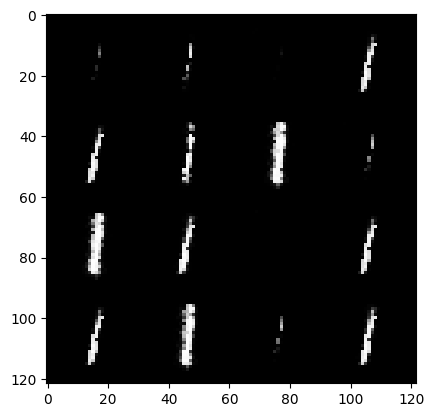

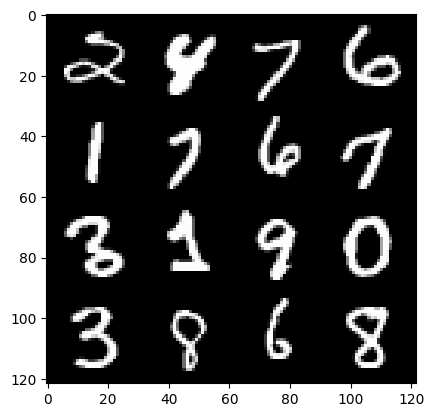

31: step 15000 / Gen loss : 7.11112533569336 /disc_loss: 0.01657585741874451 


  0%|          | 0/469 [00:00<?, ?it/s]

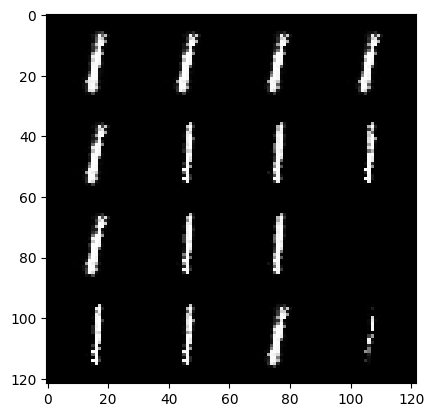

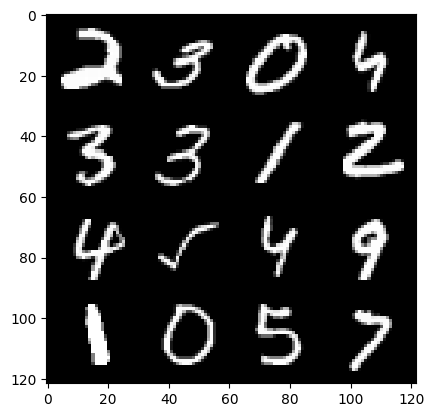

32: step 15300 / Gen loss : 6.971698945363357 /disc_loss: 0.015937774139456455 


  0%|          | 0/469 [00:00<?, ?it/s]

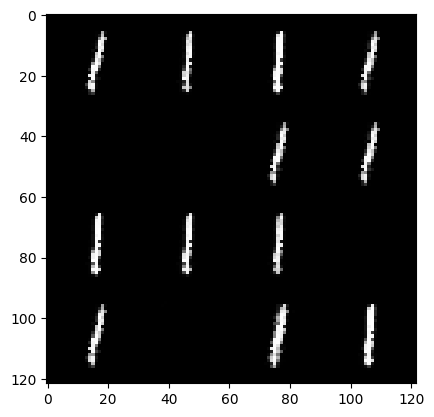

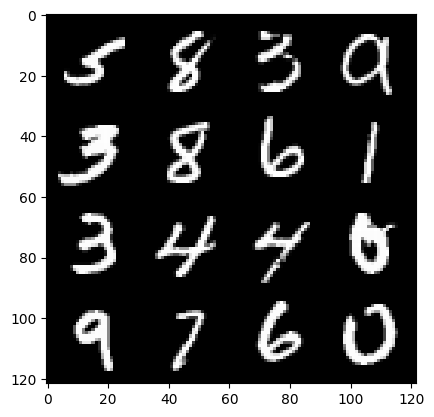

33: step 15600 / Gen loss : 7.213303675651549 /disc_loss: 0.027415230312229442 


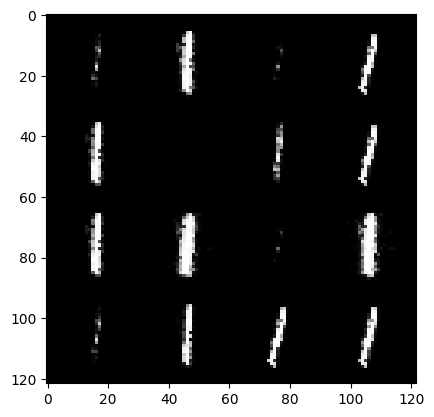

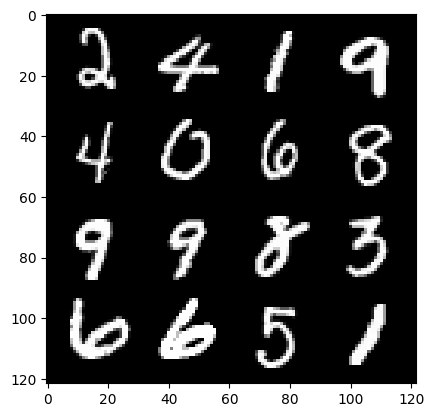

33: step 15900 / Gen loss : 6.861922494570413 /disc_loss: 0.03043545580469072 


  0%|          | 0/469 [00:00<?, ?it/s]

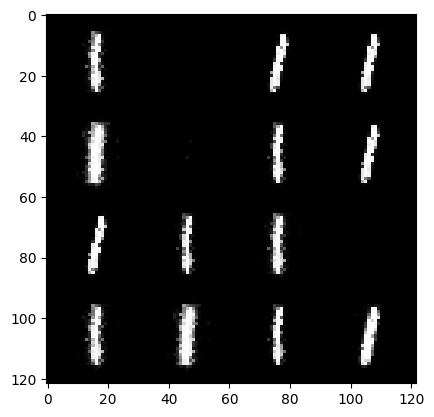

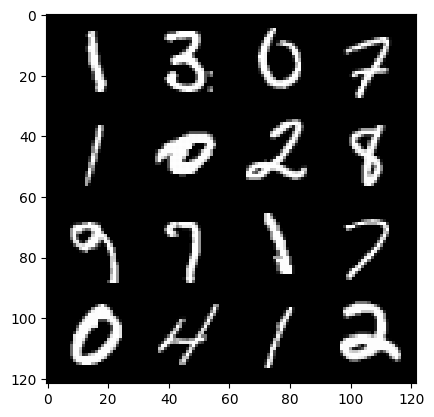

34: step 16200 / Gen loss : 6.389980832735694 /disc_loss: 0.029670424481543393 


  0%|          | 0/469 [00:00<?, ?it/s]

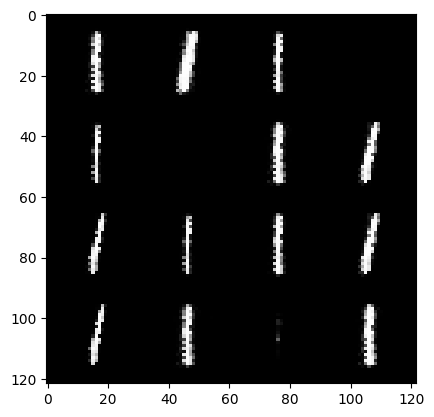

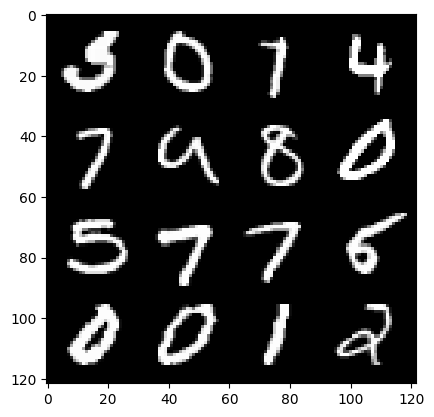

35: step 16500 / Gen loss : 6.40166779200236 /disc_loss: 0.023799688646880264 


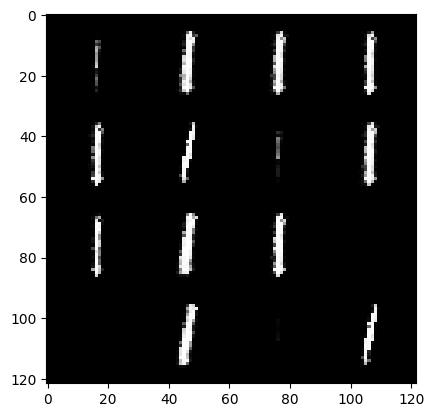

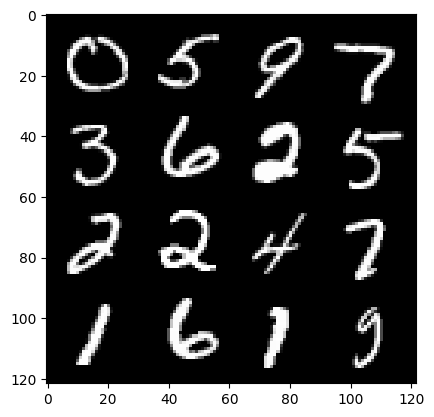

35: step 16800 / Gen loss : 6.28037238438924 /disc_loss: 0.021791280377656222 


  0%|          | 0/469 [00:00<?, ?it/s]

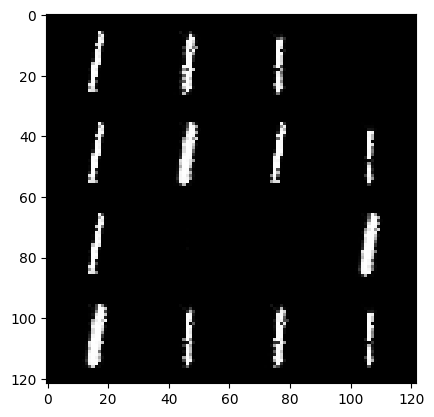

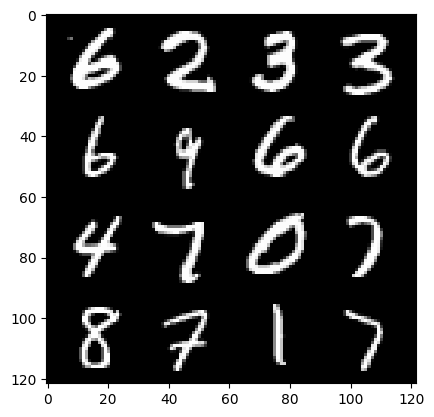

36: step 17100 / Gen loss : 6.041292891502378 /disc_loss: 0.02302423717764519 


  0%|          | 0/469 [00:00<?, ?it/s]

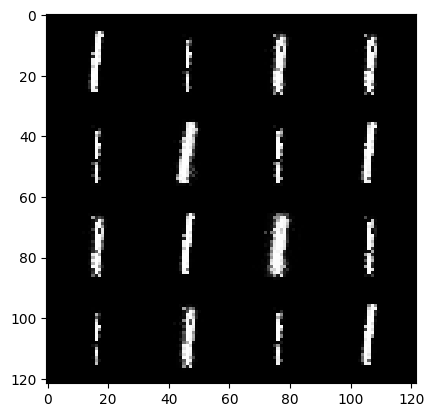

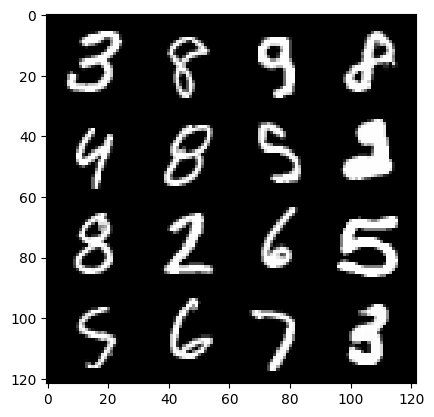

37: step 17400 / Gen loss : 6.170170923868812 /disc_loss: 0.026461662979175665 


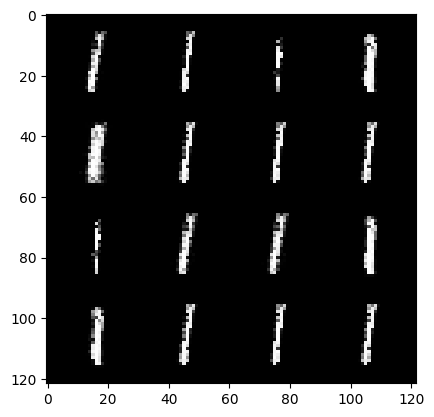

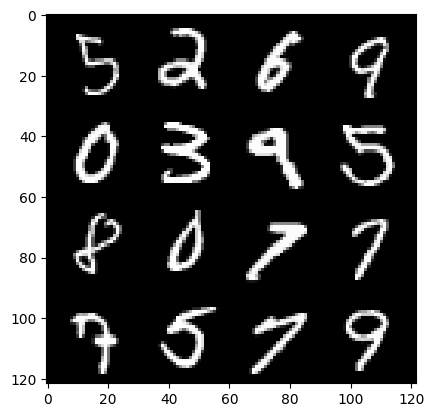

37: step 17700 / Gen loss : 6.035757357279461 /disc_loss: 0.024893201226368546 


  0%|          | 0/469 [00:00<?, ?it/s]

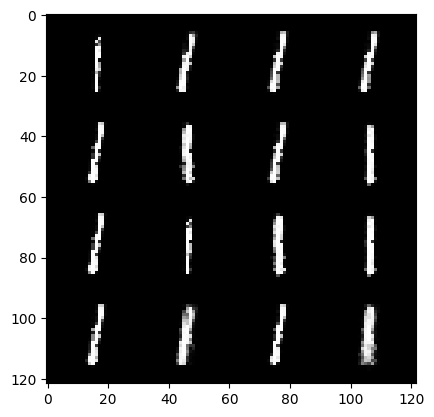

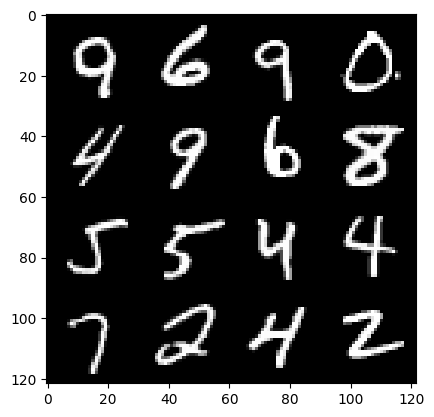

38: step 18000 / Gen loss : 5.69113679567973 /disc_loss: 0.024500568981748082 


  0%|          | 0/469 [00:00<?, ?it/s]

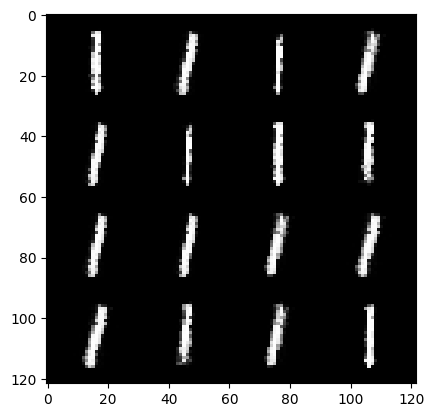

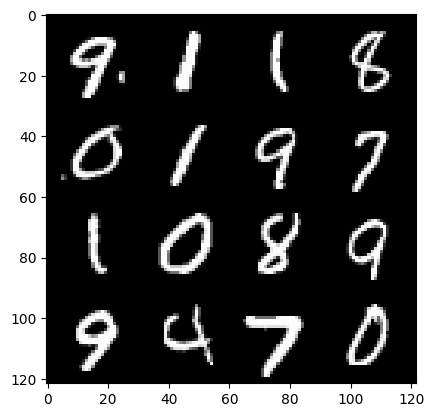

39: step 18300 / Gen loss : 5.593975243568418 /disc_loss: 0.03795339409649992 


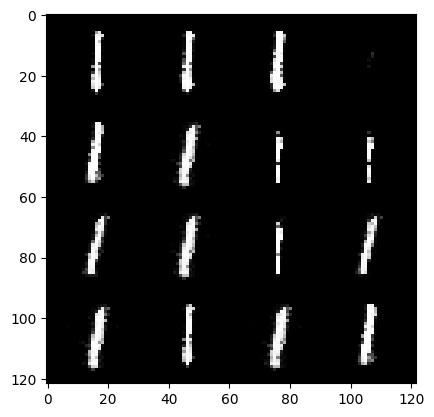

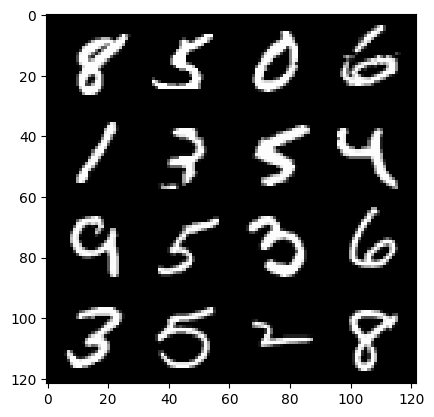

39: step 18600 / Gen loss : 5.197017606099448 /disc_loss: 0.04016040476970373 


  0%|          | 0/469 [00:00<?, ?it/s]

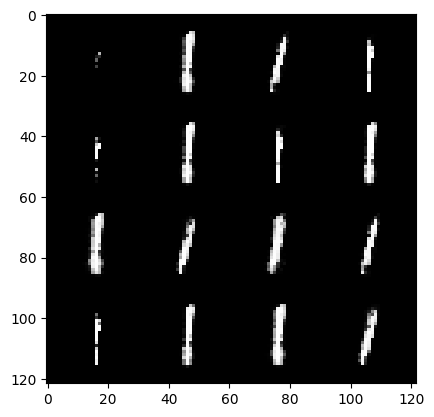

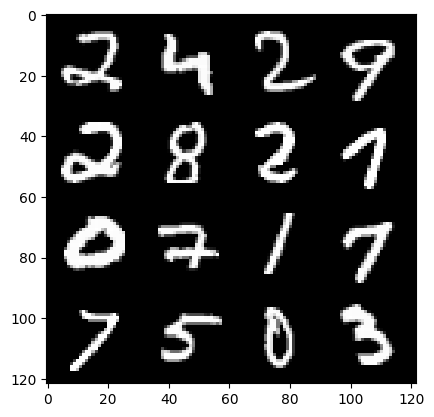

40: step 18900 / Gen loss : 5.096363960901896 /disc_loss: 0.03637336299677071 


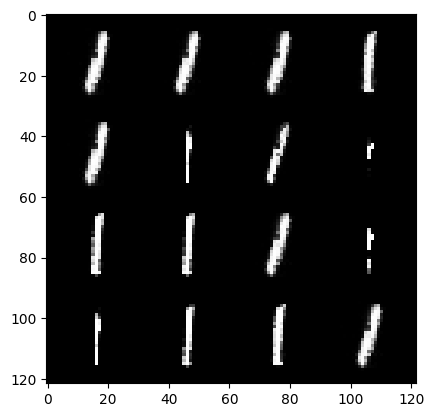

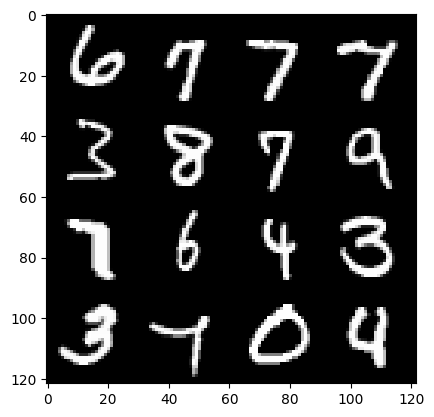

40: step 19200 / Gen loss : 5.1579551140467315 /disc_loss: 0.03793770277717463 


  0%|          | 0/469 [00:00<?, ?it/s]

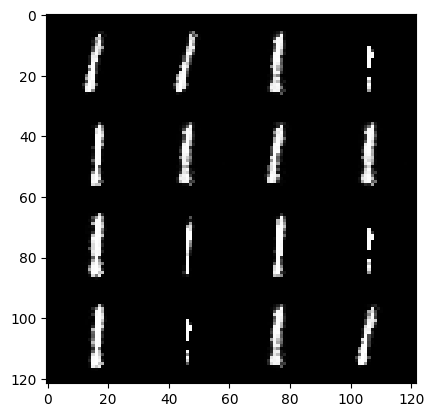

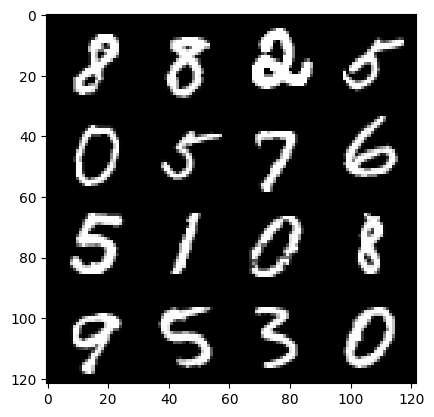

41: step 19500 / Gen loss : 4.419804220199586 /disc_loss: 0.04945148832785587 


  0%|          | 0/469 [00:00<?, ?it/s]

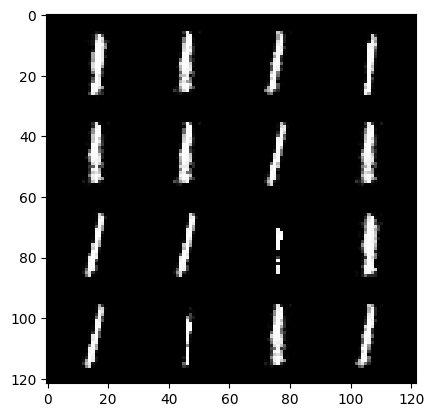

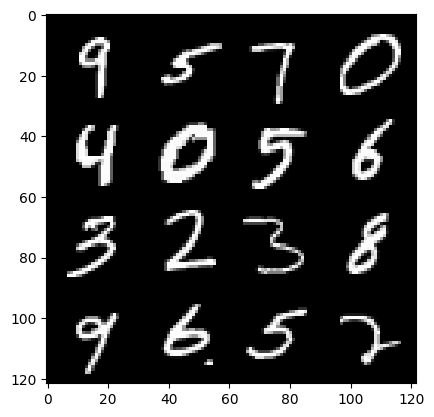

42: step 19800 / Gen loss : 4.595674224694571 /disc_loss: 0.044781784908846 


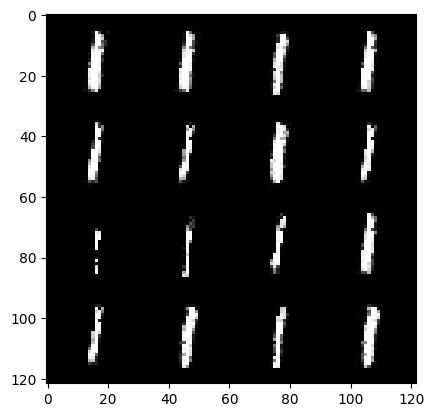

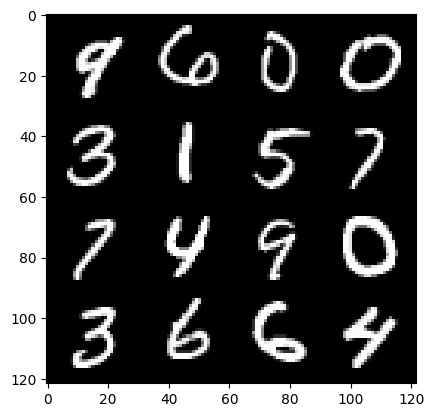

42: step 20100 / Gen loss : 4.835673267046611 /disc_loss: 0.04001655448072901 


  0%|          | 0/469 [00:00<?, ?it/s]

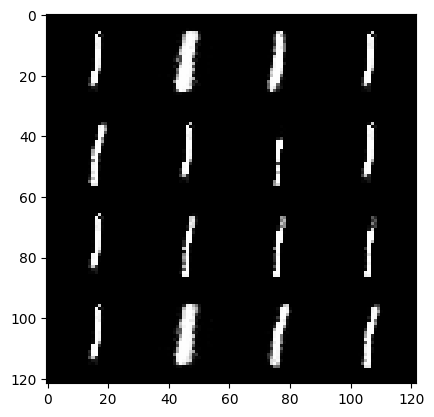

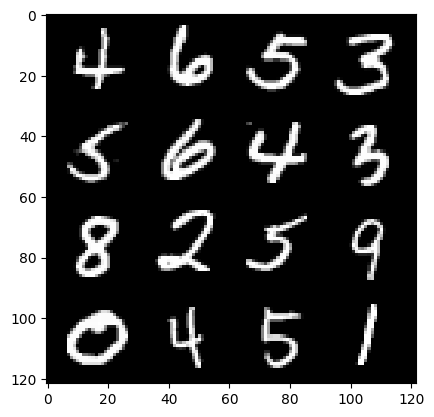

43: step 20400 / Gen loss : 4.894370319048567 /disc_loss: 0.04269753629962601 


In [ ]:
###60000/128 = 468.75 =469 steps in each epoch
### each step is going to prosess 128 images = size of the batchj (except the last step)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_opt.zero_grad()

    cur_bs=len(real) #real : 128 X 1 X 28 X 28
    real=real.view(cur_bs,-1) #128 X 784
    real=real.to(device)

    disc_loss=calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)

    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ##generator

    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ### visualization & stats

    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(cur_bs,z_dim)
      fake=gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss : {mean_gen_loss} /disc_loss: {mean_disc_loss} ")
      mean_gen_loss ,mean_disc_loss=0,0

    cur_step+=1